<a href="https://colab.research.google.com/github/tatafitz/CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание пола, расы и возраста



[Датасет](https://susanqq.github.io/UTKFace/)
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)



## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface .

In [1]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-06p2xvtk
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-06p2xvtk
  Resolved https://github.com/rcmalli/keras-vggface.git to commit 719ad75625fe51436b9a9479114b3d136847e11a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=5f94e8e98b9427a3414a2720b5dc8cc933799a633ec367e585c3f228b516aac2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ro_8_zyl/wheels/24/de/3d/9a0fad8c64abbc63b7fb8ddcdf1aa0a4c04a98d7936e989a29
Successfully built keras-vggface


In [2]:
!pip install git+https://github.com/DavidDoukhan/keras-vggface.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DavidDoukhan/keras-vggface.git to /tmp/pip-req-build-f1lqfxrm
  Running command git clone --filter=blob:none --quiet https://github.com/DavidDoukhan/keras-vggface.git /tmp/pip-req-build-f1lqfxrm
  Resolved https://github.com/DavidDoukhan/keras-vggface.git to commit 27a5bb1b5f5be568a780d0d7f9e53bdc78b763f6
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.2 MB/s eta 0:00:00
  Created wheel for keras-vggface: filename=keras_vggface-0.6_vddk_0.1-py3-none-any.whl size=8455 sha256=596b8319498630a7ec79bafa3de3d8fce10fc841e933d43ccffe53d77752d3c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-xmqzwo3q/wheels/95/e6/a7/71aedcf836a22d207dfc9c02b0bbb03294aa1be2d29a4c4a11
Failed to build keras-vggface
  Attempting uninstall: keras-vggface
    Found existing installation: keras-vggface 0.6
    Uninstalling keras-vggfac

In [72]:
import tensorflow as tf
# tf.enable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
import gdown
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from tensorflow.keras.preprocessing import image
from pathlib import Path
from collections import Counter
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [4]:
# код из https://github.com/rcmalli/keras-vggface/blob/master/README.md
# при выполнении вызовет ошибку -- это нормально

vggface_model = VGGFace(model='resnet50') # or VGGFace() as default

165445632/165439116 [==============================] - 2s 0us/step


In [5]:
! pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ResNet

In [6]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [7]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2023-01-21 19:08:57--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 104.21.83.52, 172.67.214.206, 2606:4700:3035::ac43:d6ce, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|104.21.83.52|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg [following]
--2023-01-21 19:08:57--  https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.com (img.joinfo.com)... 104.21.73.131, 172.67.162.235, 2606:4700:3031::6815:4983, ...
Connecting to img.joinfo.com (img.joinfo.com)|104.21.73.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0.01s   

2023-01-21 19:08:58 (4.09 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



После загрузки запустим полный пример из репозитория:

1351680/1346516 [==============================] - 0s 0us/step


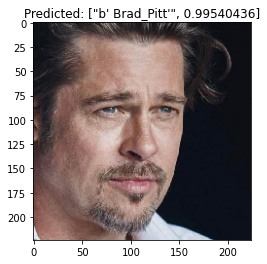

In [8]:
img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)

## Загрузка данных


In [10]:
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 145MB/s]


'train_val_split_utk.csv'

In [12]:
! wget 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=11S0ENEi0wwtoXhOP1VhNMSUwWaMpajVh' -O segment.zip

--2023-01-21 19:09:08--  https://drive.google.com/uc?export=download&confirm=no_antivirus&id=11S0ENEi0wwtoXhOP1VhNMSUwWaMpajVh
Resolving drive.google.com (drive.google.com)... 173.194.218.138, 173.194.218.101, 173.194.218.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.218.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m2k4jn5sc4qrrg667efbetv081l79n63/1674328125000/16579428900001760521/*/11S0ENEi0wwtoXhOP1VhNMSUwWaMpajVh?e=download&uuid=e0983843-f69d-4042-93d4-6b5c2bb8f5fc [following]
--2023-01-21 19:09:08--  https://doc-14-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m2k4jn5sc4qrrg667efbetv081l79n63/1674328125000/16579428900001760521/*/11S0ENEi0wwtoXhOP1VhNMSUwWaMpajVh?e=download&uuid=e0983843-f69d-4042-93d4-6b5c2bb8f5fc
Resolving doc-14-3c-docs.googleusercontent.com (doc-14-3c-docs.googleusercontent.com)

In [13]:
with zipfile.ZipFile('/content/segment.zip') as zf:
  zf.extractall()

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
data_folder = Path("/content/UTKFace")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['60_1_0_20170110122526605.jpg.chip.jpg', '27_1_3_20170112220116952.jpg.chip.jpg', '8_1_2_20170109203443934.jpg.chip.jpg']


In [79]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()


data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg


,img_name,age,race,gender
0,2_1_2_20161219151919100.jpg.chip.jpg,0.017241,2,1
1,22_1_3_20170104222612607.jpg.chip.jpg,0.189655,3,1
2,18_1_3_20170119153619553.jpg.chip.jpg,0.155172,3,1
3,1_0_0_20170110213508380.jpg.chip.jpg,0.008621,0,0
4,1_0_0_20170110211538942.jpg.chip.jpg,0.008621,0,0


In [80]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
# df[['race', 'age']] = df[['race', 'age']].astype('float32')
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [18]:
df_train

,img_name,age,race,gender,is_train
0,4_0_3_20161220220741730.jpg.chip.jpg,0.034483,3.0,0,1
1,27_0_2_20170119193327962.jpg.chip.jpg,0.232759,2.0,0,1
2,23_1_3_20170119164559398.jpg.chip.jpg,0.198276,3.0,1,1
3,3_1_2_20161219204943868.jpg.chip.jpg,0.025862,2.0,1,1
4,85_1_0_20170110181617775.jpg.chip.jpg,0.732759,0.0,1,1
...,...,...,...,...,...
23699,75_0_0_20170113185416591.jpg.chip.jpg,0.646552,0.0,0,1
23700,53_0_3_20170119201334485.jpg.chip.jpg,0.456897,3.0,0,1
23701,32_0_0_20170117130014250.jpg.chip.jpg,0.275862,0.0,0,1
23702,42_1_0_20170103183330514.jpg.chip.jpg,0.362069,0.0,1,1


In [19]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

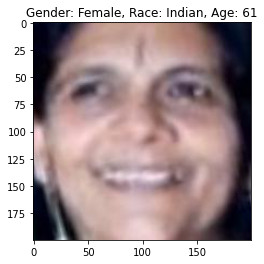

In [20]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


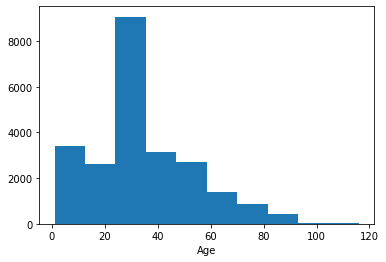

In [21]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Создание генератора данных для модели предсказания пола.


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    # < YOUR CODE STARTS HERE >
    
    preprocessed = utils.preprocess_input(image_, version=1)
    
    # < YOUR CODE ENDS HERE >
    return preprocessed

# < YOUR CODE STARTS HERE >
# image_gen должен содержать ImageDataGenerator с правильной preprocessing_function

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

# < YOUR CODE ENDS HERE >

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 224
# < YOUR CODE STARTS HERE >
train_generator = image_gen.flow_from_dataframe(dataframe=df_train,
                                                x_col='img_name',
                                                y_col='gender',
                                                batch_size=BATCH_SIZE,
                                                     directory=str(data_folder),
                                                     shuffle=True,
                                                     target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                     class_mode='binary') 
val_generator = image_gen.flow_from_dataframe(dataframe=df_val,
                                                x_col='img_name',
                                                y_col='gender',
                                              batch_size=BATCH_SIZE,
                                                     directory=str(data_folder),
                                                     shuffle=False,
                                                     target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                     class_mode='binary')


# < YOUR CODE ENDS HERE >

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [24]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Female


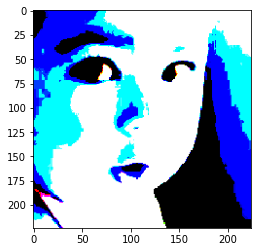

In [25]:
plt.imshow(sample_images[5])
print(gender_mapping[int(sample_labels[5])])
# мы получим очень странное изображение и это нормально. 
# matplotlib ожидает картинку с интесивностями от 0 до 1 если она типа float и от 0 до 255 если int.

In [26]:
print(sample_images[100].max(), sample_images[100].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

153.406 -129.1863


###с) Реализация функции `deprocess_image`

Female


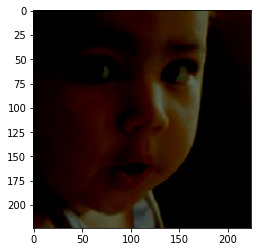

In [62]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    # < YOUR CODE STARTS HERE >
    image = np.copy(vggface_image)
    image = image[..., ::-1]
    image[..., 0] -= 30
    image[..., 1] -= 40
    image[..., 2] -= 70
    image /= 255
    # image = np.uint8(image)
    
    # < YOUR CODE ENDS HERE >
    return image

# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])])

##Обучение модели предсказания пола




In [64]:
cpt_filename = "model_gender/checkpoint_best.h5"  
cpt_path = '/'.join(["/content/drive/MyDrive", cpt_filename])
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [65]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten").output)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                             

In [66]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
# < YOUR CODE STARTS HERE >
model = tf.keras.Sequential([
  base_model,
  BatchNormalization(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


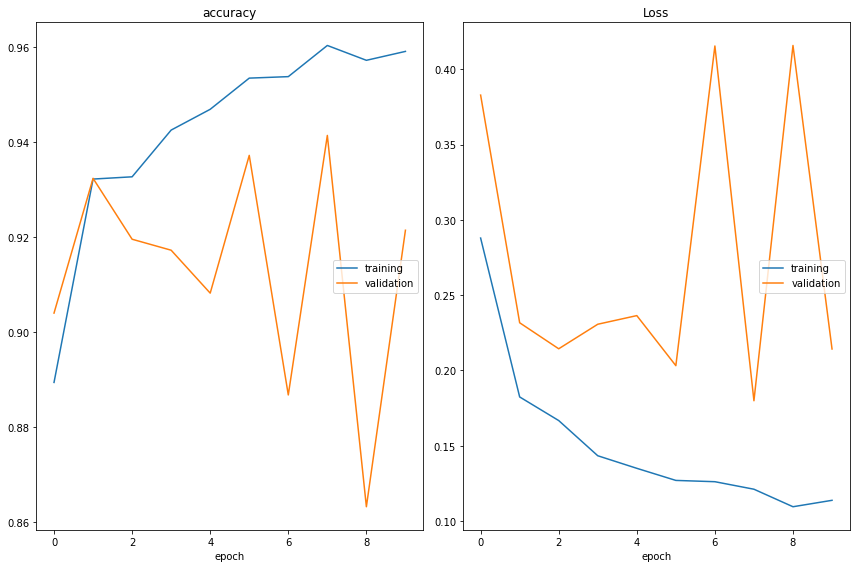

accuracy
	training         	 (min:    0.889, max:    0.960, cur:    0.959)
	validation       	 (min:    0.863, max:    0.941, cur:    0.921)
Loss
	training         	 (min:    0.110, max:    0.288, cur:    0.114)
	validation       	 (min:    0.180, max:    0.416, cur:    0.214)

Epoch 10: val_accuracy did not improve from 0.94137
25/25 [==============================] - 47s 2s/step - loss: 0.1138 - accuracy: 0.9591 - val_loss: 0.2143 - val_accuracy: 0.9214


In [68]:
EPOCHS = 10
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=25,
    callbacks=[PlotLossesCallback(), checkpoint])
# < YOUR CODE ENDS HERE >

In [69]:
model_gender =tf.keras.models.load_model('/content/drive/MyDrive/model_gender/checkpoint_best.h5')
loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 14s 337ms/step - loss: 0.1799 - accuracy: 0.9414
Well done!


In [70]:
#@title (вспомогательный код, выполните клетку)
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

4/4 [==============================] - 0s 98ms/step


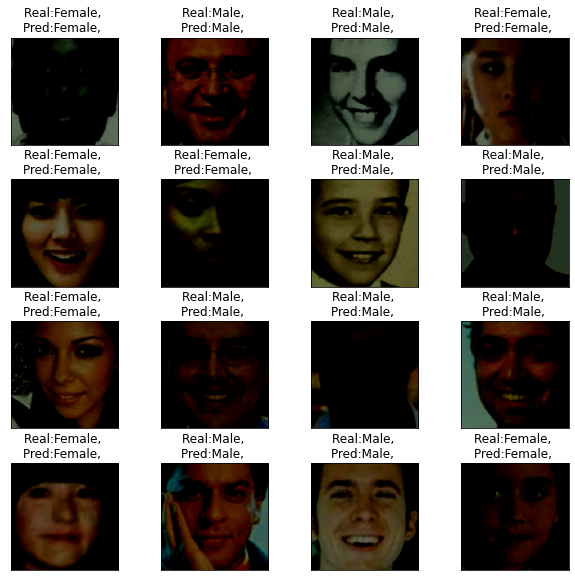

In [75]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

##Обучение модели предсказания расы





In [81]:
# < YOUR CODE STARTS HERE >
BATCH_SIZE = 128
IMAGE_SIZE = 224
# < YOUR CODE STARTS HERE >
train_generator = image_gen.flow_from_dataframe(dataframe=df_train,
                                                x_col='img_name',
                                                y_col='race',
                                                batch_size=BATCH_SIZE,
                                                     directory=str(data_folder),
                                                     shuffle=True,
                                                     target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                     class_mode='sparse') 
val_generator = image_gen.flow_from_dataframe(dataframe=df_val,
                                                x_col='img_name',
                                                y_col='race',
                                              batch_size=BATCH_SIZE,
                                                     directory=str(data_folder),
                                                     shuffle=False,
                                                     target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                     class_mode='sparse')

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [82]:
cpt_filename = "model_race/checkpoint_best.h5"  
cpt_path = '/'.join(["/content/drive/MyDrive", cpt_filename])
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [84]:
base_model_2 = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten").output)

In [85]:
# Обучение модели предсказания расы
model = tf.keras.Sequential([
  base_model_2,
  BatchNormalization(),
  tf.keras.layers.Dense(5, activation='softmax')
])
scce = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=scce,
              metrics=['accuracy'])

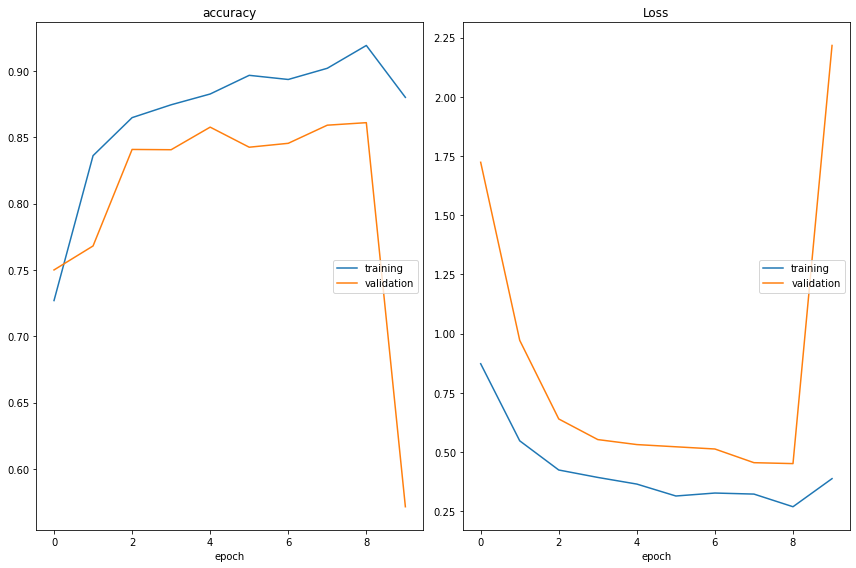

accuracy
	training         	 (min:    0.727, max:    0.919, cur:    0.880)
	validation       	 (min:    0.572, max:    0.861, cur:    0.572)
Loss
	training         	 (min:    0.269, max:    0.872, cur:    0.387)
	validation       	 (min:    0.451, max:    2.216, cur:    2.216)

Epoch 10: val_accuracy did not improve from 0.86090
25/25 [==============================] - 45s 2s/step - loss: 0.3872 - accuracy: 0.8800 - val_loss: 2.2164 - val_accuracy: 0.5715


In [86]:
EPOCHS = 10
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=25,
    callbacks=[PlotLossesCallback(), checkpoint])
# < YOUR CODE ENDS HERE >

In [87]:
model_race = tf.keras.models.load_model("/content/drive/MyDrive/model_race/checkpoint_best.h5")
loss, acc = model_race.evaluate(val_generator)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 14s 358ms/step - loss: 0.4507 - accuracy: 0.8609
Well done!


4/4 [==============================] - 1s 91ms/step


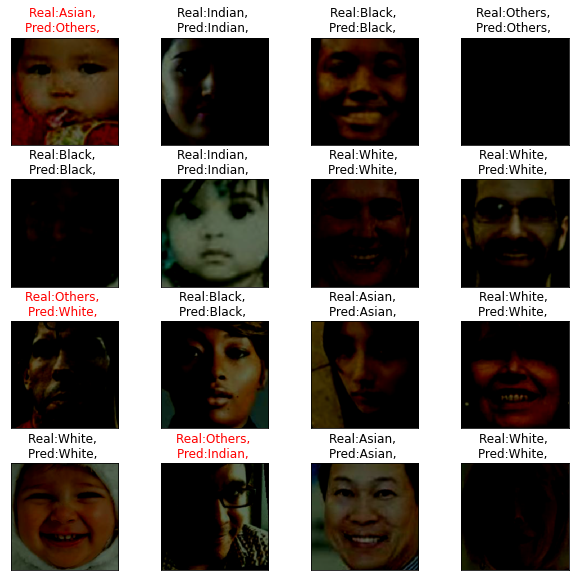

In [88]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Задание 5. Multitask learning

Классификация пола (1 выход, вероятность), классификацию расы (5 выходов, вероятности) и предсказание возраста (1 выход, число).

In [89]:
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten").output)
base_model.trainable = False

In [90]:
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                           

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 2048)         23561152    ['input_2[0][0]']                
                                                                                                  
 Layer_last1 (Dense)            (None, 2500)         5122500     ['model_2[0][0]']                
                                                                                                  
 Layer_last2 (Dense)            (None, 2000)         5002000     ['Layer_last1[0][0]']      

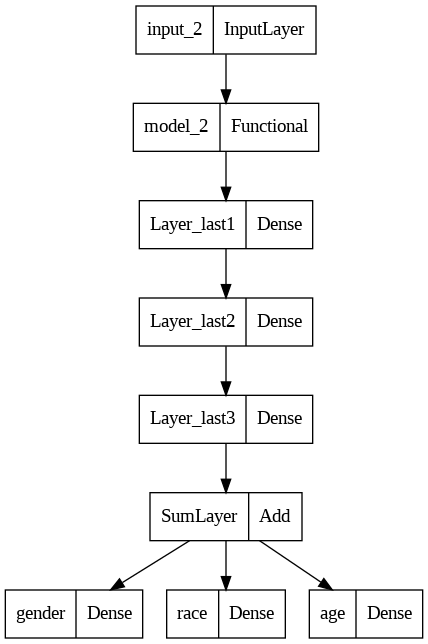

In [91]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

BATCH_SIZE = 128
IMAGE_SIZE = 224

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
l0_output = base_model(input_layer)
# переменная model должна содержать модель для дальнейшего обучения

l1_output = tf.keras.layers.Dense(2500, name="Layer_last1", activation='relu')(l0_output)
# l2_output = tf.keras.layers.Flatten()(l1_output)
l2_output = tf.keras.layers.Dense(2000, name="Layer_last2", activation='relu')(l1_output)
l3_output = tf.keras.layers.Dense(1800, name="Layer_last3", activation='relu')(l2_output)
# l4_output = tf.keras.layers.Dense(1800, name="Layer_last4", activation='relu')(l3_output)
# специальный слой, который сложит выходы всех слоев, которые ему передали
sum_output = tf.keras.layers.Add(name="SumLayer")([l3_output])

# выходной слой
output_gender = tf.keras.layers.Dense(1, name="gender", activation='sigmoid')(sum_output)
output_race = tf.keras.layers.Dense(5, name="race", activation='softmax')(sum_output)
output_age = tf.keras.layers.Dense(1, name="age", activation='sigmoid')(sum_output)
# дальше будем определять чуть компактнее


# создаем модель. нужно показать что мы считаем входом в нашу модель, а что выходом.
model = tf.keras.Model(inputs=input_layer, outputs=[output_gender, output_race, output_age])

tf.keras.utils.plot_model(model, show_shapes=False)








# < YOUR CODE ENDS HERE >
model.summary()
plot_model(model)


In [92]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


Ниже мы приводим необходимые генераторы данных. Обратите внимание на y_col и class_mode.


In [93]:
from livelossplot import PlotLossesKeras

In [94]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False)

def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1], 3, axis=1) #выделяем набор всех 3 меток, дальше выделять каждую метку не нужно
        labels = np.array(labels).astype('float32')
        labels = [labels[0].reshape((len(labels[0]),)),
                  labels[1].reshape((len(labels[1]),)),
                  labels[2].reshape((len(labels[2]),))]
        yield image, labels


Found 18946 validated image filenames.
Found 4759 validated image filenames.


In [95]:
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


А теперь перейдем к обучению:

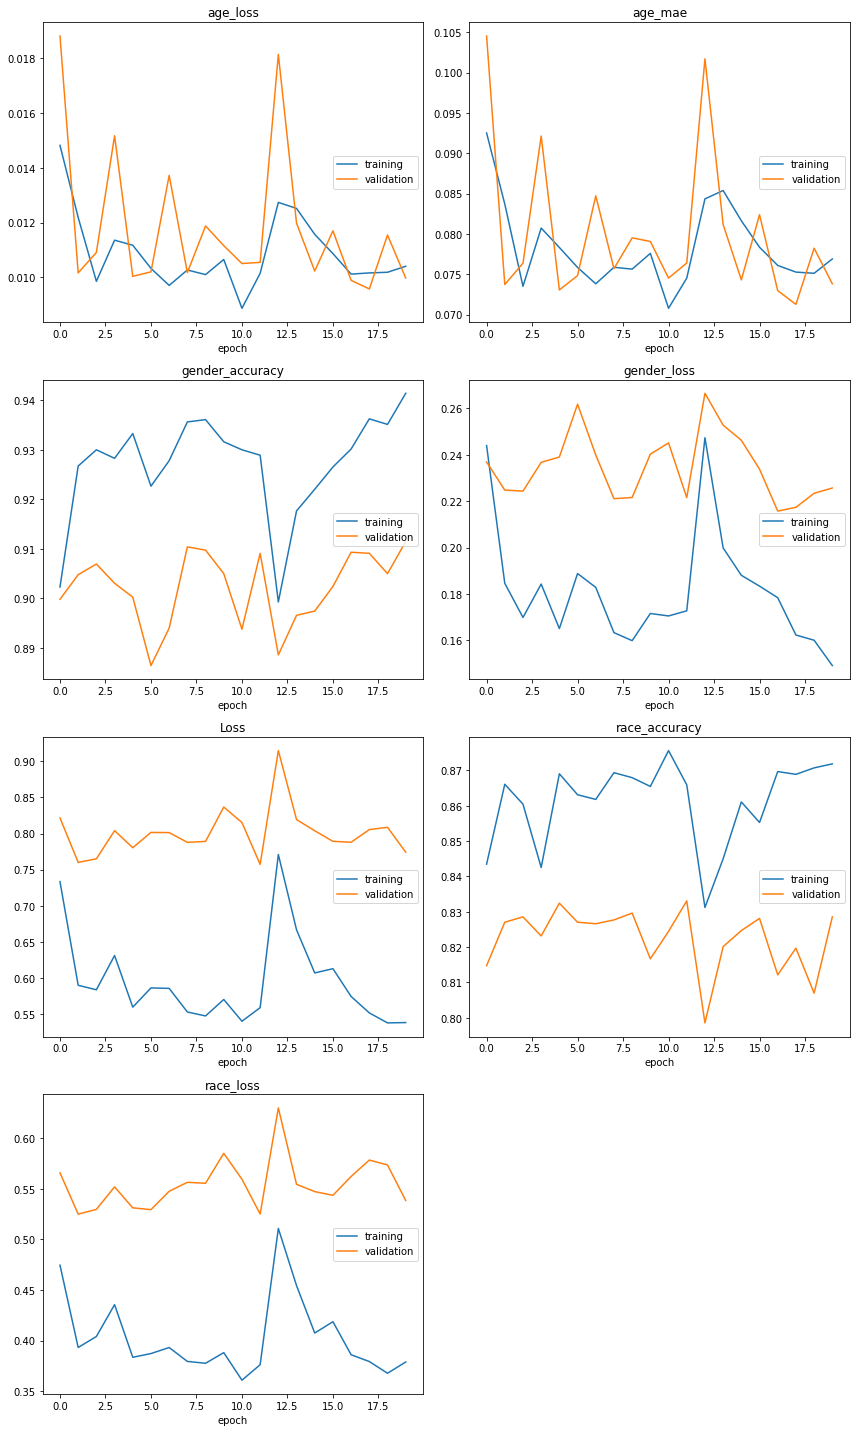

age_loss
	training         	 (min:    0.009, max:    0.015, cur:    0.010)
	validation       	 (min:    0.010, max:    0.019, cur:    0.010)
age_mae
	training         	 (min:    0.071, max:    0.093, cur:    0.077)
	validation       	 (min:    0.071, max:    0.105, cur:    0.074)
gender_accuracy
	training         	 (min:    0.899, max:    0.941, cur:    0.941)
	validation       	 (min:    0.886, max:    0.911, cur:    0.911)
gender_loss
	training         	 (min:    0.149, max:    0.247, cur:    0.149)
	validation       	 (min:    0.216, max:    0.267, cur:    0.226)
Loss
	training         	 (min:    0.538, max:    0.771, cur:    0.538)
	validation       	 (min:    0.757, max:    0.915, cur:    0.774)
race_accuracy
	training         	 (min:    0.831, max:    0.876, cur:    0.872)
	validation       	 (min:    0.799, max:    0.833, cur:    0.829)
race_loss
	training         	 (min:    0.361, max:    0.511, cur:    0.379)
	validation       	 (min:    0.525, max:    0.630, cur:    0.539)

E

In [122]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # вы можете выбрать другую скорость обучения для вашей модели

# обратите внимание, что теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics
model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})


# path = Path("model_multitask")
# path.mkdir(exist_ok=True)
cpt_filename = "model_multitask/checkpoint_best.h5"
# cpt_path = '/'.join(["/content/drive/MyDrive", cpt_filename])
# cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_filename, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min')

history = model.fit(split_outputs(train_generator), epochs=20, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesKeras(), checkpoint], steps_per_epoch=50, 
                    validation_steps= len(df_val) // BATCH_SIZE)

In [123]:
# model_multitask = tf.keras.models.load_model("/content/model_multitask/checkpoint_best.h5")
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
# print(results)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

Found 4759 validated image filenames.
37/37 [==============================] - 13s 351ms/step - loss: 0.7709 - gender_loss: 0.2228 - race_loss: 0.5382 - age_loss: 0.0099 - gender_accuracy: 0.9128 - race_accuracy: 0.8285 - age_mae: 0.0734
Well done!


4/4 [==============================] - 0s 97ms/step


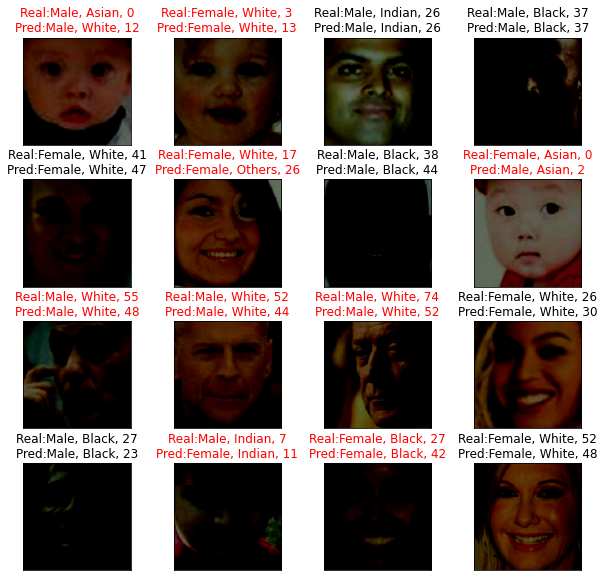

In [126]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

###b)
Загрузите любое лицо и получите предсказание. Не забудьте его обрезать соответствующим образом. Результат сети не оценивается.

In [128]:
! wget https://cdnn1.img.sputnik.tj/img/07e6/0c/1f/1053948999_0:155:3164:1936_1920x0_80_0_0_847f06f5504c95fe30faa26d0eb977a9.jpg.webp -O put.jpg

--2023-01-21 21:06:48--  https://cdnn1.img.sputnik.tj/img/07e6/0c/1f/1053948999_0:155:3164:1936_1920x0_80_0_0_847f06f5504c95fe30faa26d0eb977a9.jpg.webp
Resolving cdnn1.img.sputnik.tj (cdnn1.img.sputnik.tj)... 185.40.155.13
Connecting to cdnn1.img.sputnik.tj (cdnn1.img.sputnik.tj)|185.40.155.13|:443... ^C


Downloading...
From: https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1UAgE3qFd9_nph2NLTa6itLRH6w35BmaB
To: /content/me.jpg
100%|██████████| 4.18M/4.18M [00:00<00:00, 231MB/s]


1/1 [==============================] - 0s 22ms/step


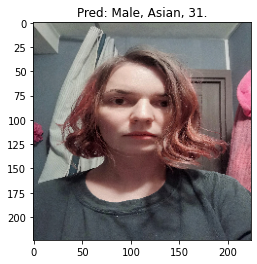

In [131]:
url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1UAgE3qFd9_nph2NLTa6itLRH6w35BmaB'
output = 'me.jpg'
gdown.download(url, output, quiet=False)

img = image.load_img("me.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)
#про пол обидно немного...